In [8]:
# ! pip install newsapi-python

SyntaxError: invalid syntax (<ipython-input-8-24a666b469b3>, line 1)

In [2]:
import os

from newsapi import NewsApiClient
from tqdm import tqdm

from keybert import KeyBERT

import pandas as pd
import pickle

from itertools import chain
from collections import Counter

import datetime as DT

In [77]:
# api request를 정하는 부분으로 신중하게 확인할
from_date = '2023-07-03'
to_date = '2023-07-04'
query = 'bank' or 'banking' # 키워드
pages = range(1,6) # 무료 api는 일일당 5page(500개 뉴스)가 최대. # 그런데 반드시 500개를 할 필요는 없어보임. 키워드와 관련 없는 뉴스일 가능성이 높기 때문에

In [78]:
# 환경 설정
cwd = os.getcwd()
main_path = cwd + '/' + query 

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

createFolder(main_path)
createFolder(main_path + '/' + 'dataByDate')

In [79]:
# 데이터 수집(api)
f=open("/Users/jyp/Desktop/NH/newsapi_api_key.txt","rt")
while True:
    api_key = f.read() 
    break
f.close()

In [80]:
 # api 횟수가 차감되는 부분으로 신중히 돌릴것
newsapi = NewsApiClient(api_key='c91c6398380e4b84a34a4246fb0a3218') # 할당받은 API 키 입력
news = []
urls = []
dates = []
for page in pages:
    print(page)
    all_articles = newsapi.get_everything(q=query,
                                          from_param=from_date,
                                          to=to_date,
                                          language='en',
                                          sort_by='relevancy',
                                          page=page)

    for article in all_articles['articles']:
        
        title = article['title']
        description = article['description']
        content = '. '.join([title,description]) if description != None and title != None else '' 
        
        url = article['url']
        
        publishedAt = article['publishedAt'][:10]
        
        news.append(content)
        urls.append(url)
        dates.append(publishedAt)

1
2
3
4
5


In [81]:
# 키워드 추출

def doc2key(content,kw_model):
    
    keywords = kw_model.extract_keywords(content, keyphrase_ngram_range=(1, 1), use_mmr=True,diversity=0.7,stop_words='english', top_n=10)
    
    keywords = [a[0] for a in keywords if a[1] >= 0.25 ]
    
    return keywords

kw_model = KeyBERT(model='all-MiniLM-L6-v2')
keywords = []
for content in tqdm(news):
    keyword = doc2key(content,kw_model)
    keywords.append(keyword)

100%|██████████| 500/500 [00:53<00:00,  9.39it/s]


In [82]:
# html에서 추출한 정보를 dataframe으로 만들고 저장.
data = pd.DataFrame({'date':dates,'news':news,'url':urls,'keyword':keywords})

name = "dataByDate_{}_{}.pickle".format(from_date,to_date)
name = name.replace('/','.')
with open(main_path + '/' + 'dataByDate/' + name,'wb') as f:
    pickle.dump(data,f)

In [88]:
# 키워드 카운트
DataCountByDay = pd.DataFrame(Counter(list(chain(*data['keyword'].values))),index = [from_date])
DataCountByDay = DataCountByDay.T

In [89]:
# 워드 클라우드
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.pyplot import figure
from wordcloud import (WordCloud, get_single_color_func)
import numpy as np
def DrawPointColoredWC(tags,title,cwd,searching_word, drop_list=[], color = '#00ff00', pointed_list=[]):
    color_to_words = {
        color : pointed_list
    }

    use_tags = tags.drop(drop_list, errors = 'ignore')
    wc = WordCloud(font_path='/System/Library/Fonts/Supplemental/Arial Unicode.ttf',background_color="white",width=1600, height=800,random_state = 1)

    default_color = 'black'
    grouped_color_func = GroupedColorFunc(color_to_words, default_color)

    cloud = wc.generate_from_frequencies(dict(use_tags))
    wc.recolor(color_func=grouped_color_func)

    figure(dpi=1200)
    figure(figsize=[12,8])
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.savefig(cwd + '/' + searching_word + '/'+ title + ' 강조'+'.pdf')
    plt.show()
    
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [90]:
# 최대 키워드 수, 지울 단어, 강조할 단어 지정
num_exp = 50
drop_list = [np.nan,'economy','finance','banks','bank','sustainability','stocks','2023','2022','thomson','httpswww','review','review terms','sure','reuters','terms','theres','happen','cookies','content','javascript','browser','supports javascript','did happen','loading information', '2024','economic','businesses']
num = num_exp + len(drop_list)
color_to_words = {
    '#00ff00': []
}

2023-07-03에서 2023-07-04까지 키워드 출현 빈도 순 상위 50개 입니다


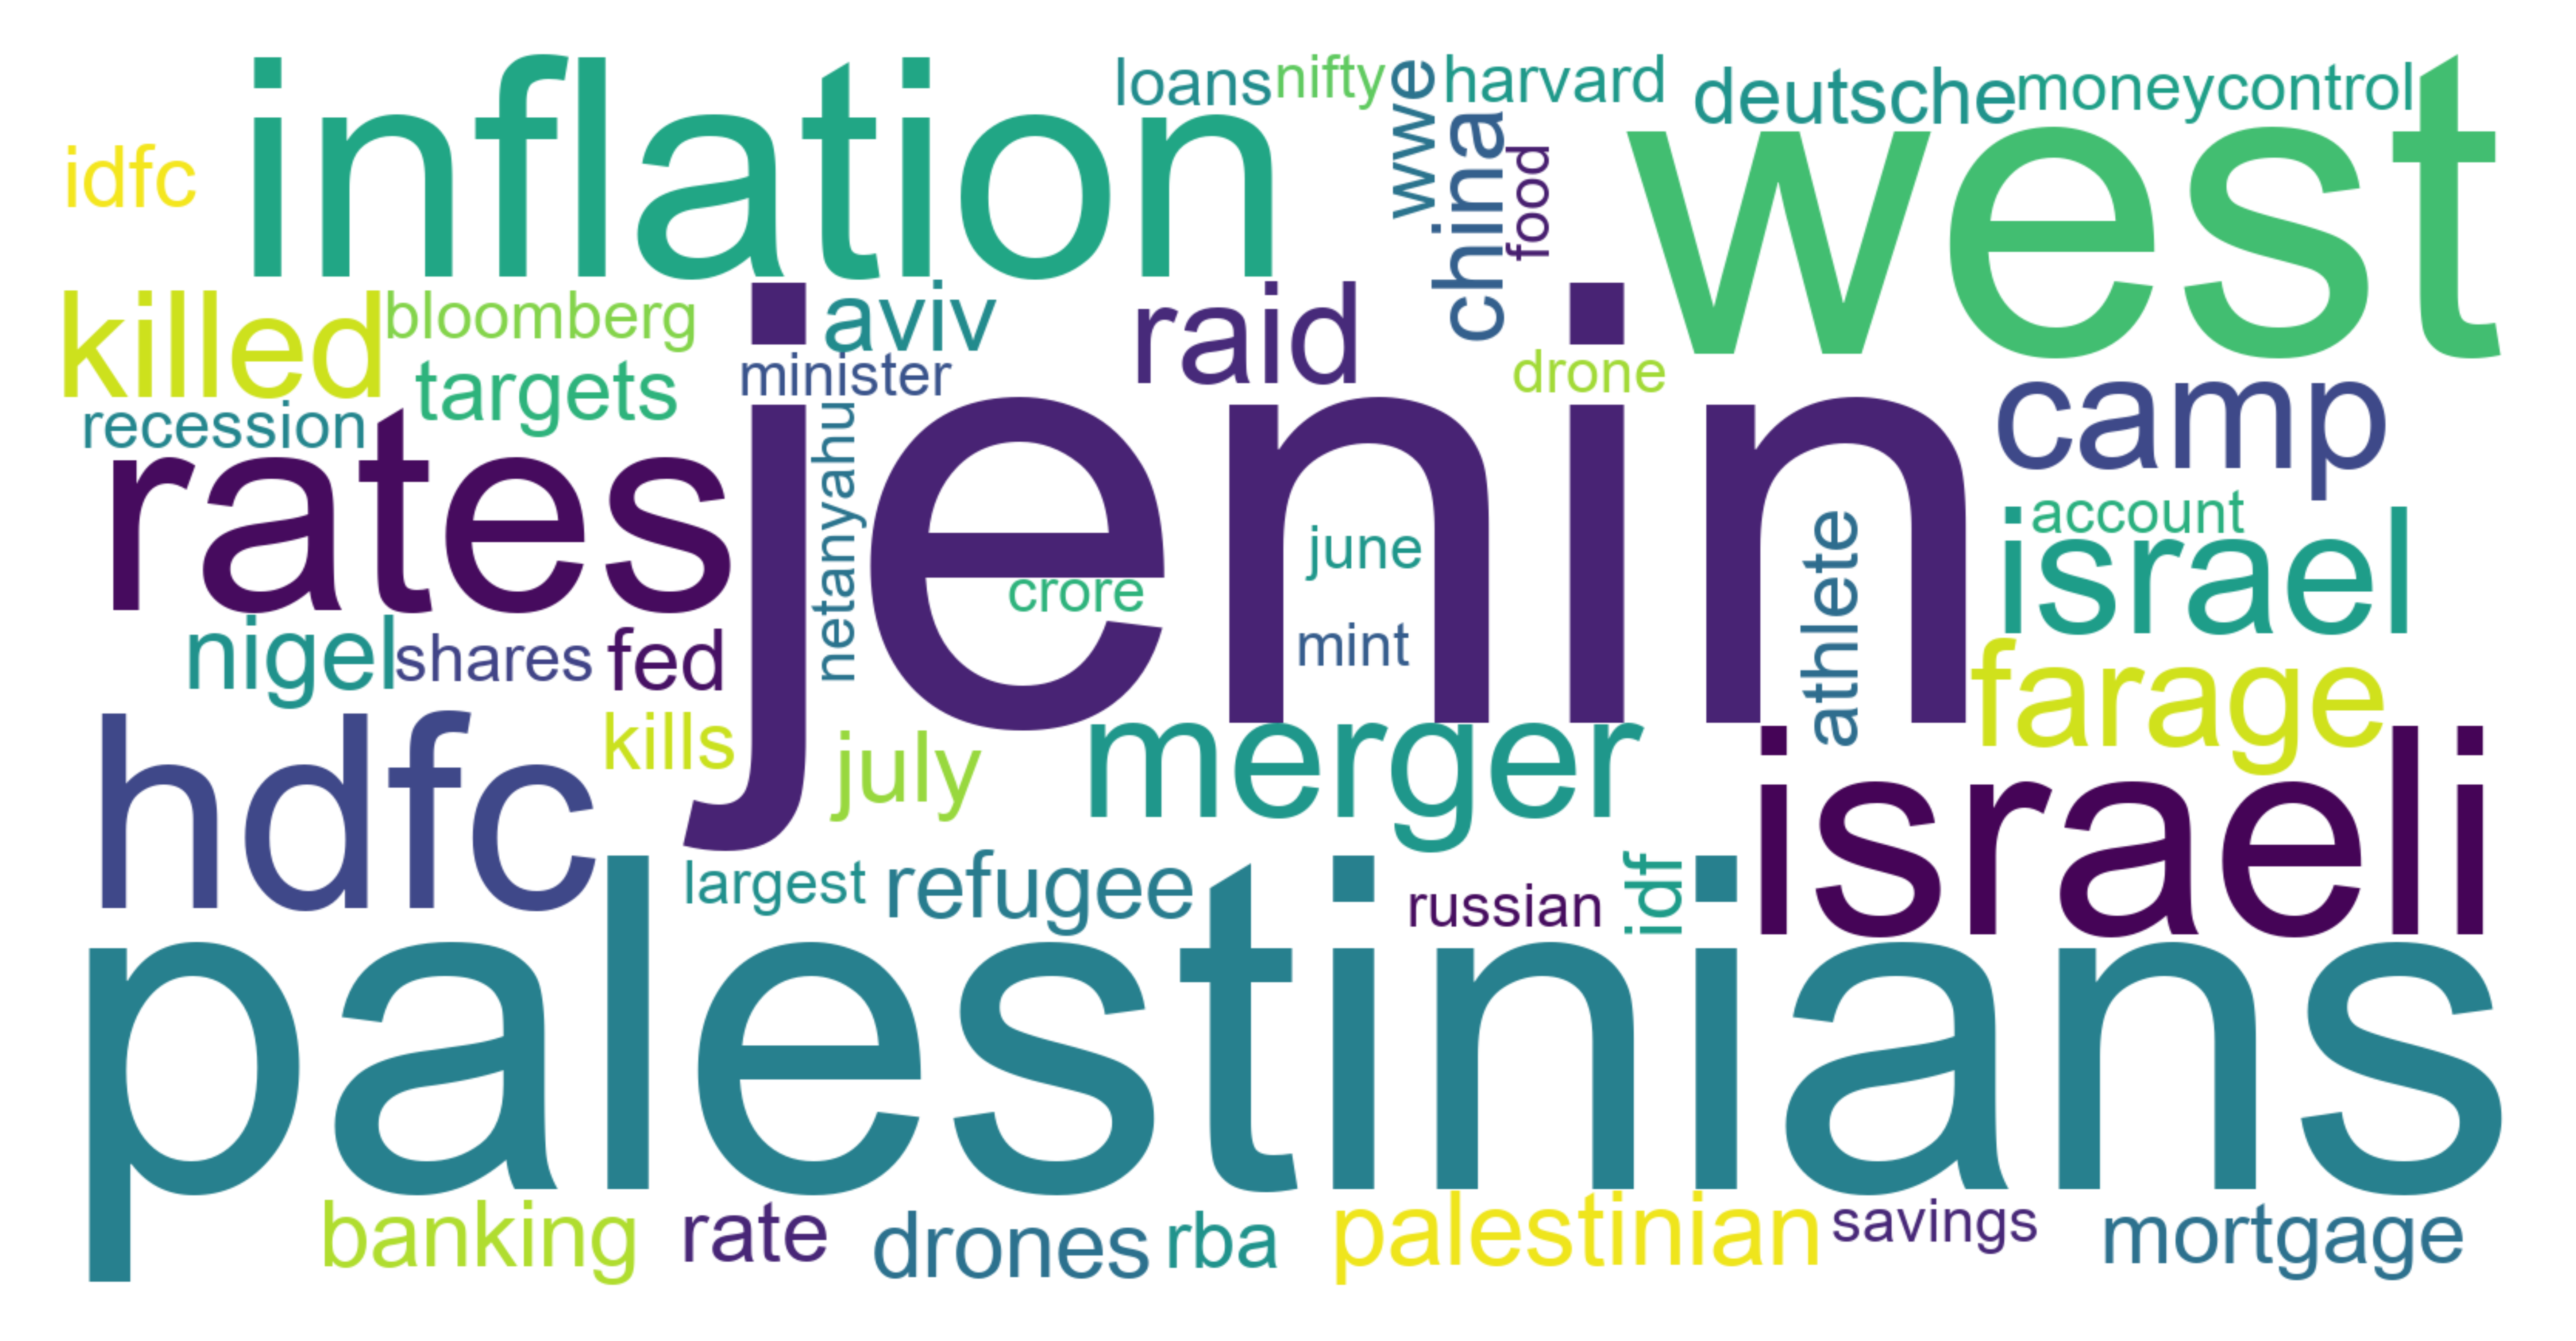

In [91]:
# 그림 그리기 및 저장
tags = DataCountByDay.sort_values(by = from_date, ascending = False)[1:num+1][from_date]
tags = tags.drop(drop_list, errors = 'ignore')[:num_exp]
tags.to_excel('bank' + '_' + from_date + '_' + to_date + '.xlsx') # 빈도순 50개 엑셀로 저장
print('{}에서 {}까지 키워드 출현 빈도 순 상위 {}개 입니다'.format(from_date,to_date,num_exp))
wc = WordCloud(font_path='/System/Library/Fonts/Supplemental/Arial Unicode.ttf',background_color="white",width=1600, height=800,random_state = 1)
# default_color = 'black'
# grouped_color_func = GroupedColorFunc(color_to_words, default_color)

cloud = wc.generate_from_frequencies(dict(tags))
# wc.recolor(color_func=grouped_color_func)

figure(dpi=1200)
title = 'bank_빈도순 상위_{}개'.format(str(len(tags)))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.savefig(cwd + '/' + query + '/'+ title + '_' + from_date + '_' + to_date + '.pdf')
plt.show()

In [92]:
# raw data 저장
import pickle

bank=pickle.load(open('/Users/jyp/Desktop/NH/economy/dataByDate/dataByDate_2023-06-26_2023-07-02.pickle', 'rb'))
bank.to_excel('raw_bank' + '_' + from_date + '_' + to_date + '.xlsx')